In [3]:
import os, time, json, logging, requests
from datetime import datetime

logging.basicConfig(level=logging.INFO, 
                    format="%(asctime)s %(levelname)s %(message)s")

/Users/jihangbc.edu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
import pandas as pd
import os

BASE_DIR = "/Users/jihangbc.edu/Downloads"

def load_ctd_file(filename):
    file_path = os.path.join(BASE_DIR, filename)
    df = pd.read_csv(
        file_path,
        sep="\t",
        skiprows=27,       
        compression="gzip",
        encoding="utf-8"
    )
    print(f"Loaded {filename} with shape: {df.shape}")
    print(df.columns.tolist()) 
    return df

chem_df = load_ctd_file("CTD_chemicals.tsv.gz")
ixn_df = load_ctd_file("CTD_chem_gene_ixns.tsv.gz")


2025-07-09 14:58:40,460 INFO NumExpr defaulting to 8 threads.


Loaded CTD_chemicals.tsv.gz with shape: (179399, 8)
['# ChemicalName', 'ChemicalID', 'CasRN', 'Definition', 'ParentIDs', 'TreeNumbers', 'ParentTreeNumbers', 'Synonyms']
Loaded CTD_chem_gene_ixns.tsv.gz with shape: (2972845, 11)
['# ChemicalName', 'ChemicalID', 'CasRN', 'GeneSymbol', 'GeneID', 'GeneForms', 'Organism', 'OrganismID', 'Interaction', 'InteractionActions', 'PubMedIDs']


In [33]:
ixn_df.columns = ixn_df.columns.str.strip().str.replace("# ", "")
chem_df.columns = chem_df.columns.str.strip().str.replace("# ", "")

chem_df_clean = chem_df.copy()
chem_df_clean["ChemicalID"] = chem_df_clean["ChemicalID"].str.replace("MESH:", "", regex=False)

ixn_full = ixn_df.merge(
    chem_df_clean,
    on="ChemicalID",
    how="left",
    suffixes=("_ixn", "_chem")  
)

check_cols = ["ChemicalName", "CasRN"]
for col in check_cols:
    comp = ixn_full[f"{col}_ixn"] == ixn_full[f"{col}_chem"]
    consistency = comp.mean()
    print(f"✅ Consistency Check：{col}_ixn == {col}_chem → {consistency:.2%} consistent")
    
    if consistency == 1.0:
        ixn_full = ixn_full.drop(columns=[f"{col}_ixn"])
        ixn_full = ixn_full.rename(columns={f"{col}_chem": col})
    else:
        print(f"⚠️ Attention：{col} are inconsistent; it is recommended to retain both columns for manual verification.")

print("✔️ Done. Show head：")
ixn_full.head()

✅ Consistency Check：ChemicalName_ixn == ChemicalName_chem → 100.00% consistent
✅ Consistency Check：CasRN_ixn == CasRN_chem → 72.35% consistent
⚠️ Attention：CasRN are inconsistent; it is recommended to retain both columns for manual verification.
✔️ Done. Show head：


,ChemicalID,CasRN_ixn,GeneSymbol,GeneID,GeneForms,Organism,OrganismID,Interaction,InteractionActions,PubMedIDs,ChemicalName,CasRN_chem,Definition,ParentIDs,TreeNumbers,ParentTreeNumbers,Synonyms
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#,NaN,NaN,NaN,NaN,NaN,NaN
1,C534883,NaN,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 affects the reaction [MYC protein res...,affects^reaction|increases^expression,32184358,10074-G5,NaN,NaN,MESH:D010069,D03.383.129.462.580/C534883,D03.383.129.462.580,NaN
2,C534883,NaN,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 inhibits the reaction [EPHB2 protein ...,decreases^reaction|increases^expression,32184358,10074-G5,NaN,NaN,MESH:D010069,D03.383.129.462.580/C534883,D03.383.129.462.580,NaN
3,C534883,NaN,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,decreases^expression,32184358,10074-G5,NaN,NaN,MESH:D010069,D03.383.129.462.580/C534883,D03.383.129.462.580,NaN
4,C534883,NaN,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,decreases^expression,32184358,10074-G5,NaN,NaN,MESH:D010069,D03.383.129.462.580/C534883,D03.383.129.462.580,NaN


In [6]:
ixn_full = ixn_full.drop(columns=["CasRN_ixn", "CasRN_chem"], errors="ignore")
ixn_full

,ChemicalID,GeneSymbol,GeneID,GeneForms,Organism,OrganismID,Interaction,InteractionActions,PubMedIDs,ChemicalName,Definition,ParentIDs,TreeNumbers,ParentTreeNumbers,Synonyms
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#,NaN,NaN,NaN,NaN,NaN
1,C534883,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 affects the reaction [MYC protein res...,affects^reaction|increases^expression,32184358,10074-G5,NaN,MESH:D010069,D03.383.129.462.580/C534883,D03.383.129.462.580,NaN
2,C534883,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 inhibits the reaction [EPHB2 protein ...,decreases^reaction|increases^expression,32184358,10074-G5,NaN,MESH:D010069,D03.383.129.462.580/C534883,D03.383.129.462.580,NaN
3,C534883,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,decreases^expression,32184358,10074-G5,NaN,MESH:D010069,D03.383.129.462.580/C534883,D03.383.129.462.580,NaN
4,C534883,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,decreases^expression,32184358,10074-G5,NaN,MESH:D010069,D03.383.129.462.580/C534883,D03.383.129.462.580,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972840,D015054,VEGFA,7422.0,protein,Mus musculus,10090.0,TNFRSF1A gene mutant form inhibits the reactio...,decreases^reaction|increases^expression,17724436,Zymosan,NaN,MESH:D047071,D09.698.365.089.750,D09.698.365.089,Zymosan A|Zymosans
2972841,D015054,VEGFA,7422.0,protein,Mus musculus,10090.0,Zymosan results in increased expression of VEG...,increases^expression,17724436,Zymosan,NaN,MESH:D047071,D09.698.365.089.750,D09.698.365.089,Zymosan A|Zymosans
2972842,D015054,XIAP,331.0,mRNA,Homo sapiens,9606.0,Zymosan analog results in decreased expression...,decreases^expression,16803582,Zymosan,NaN,MESH:D047071,D09.698.365.089.750,D09.698.365.089,Zymosan A|Zymosans
2972843,C015582,CYP27A1,1593.0,protein,Homo sapiens,9606.0,CYP27A1 protein results in increased metabolis...,increases^metabolic processing,14622972,zymosterol,NaN,MESH:D002784,D04.210.500.247.222.284/C015582|D04.210.500.24...,D04.210.500.247.222.284|D04.210.500.247.808.19...,"5 alpha-cholesta-8,24-dien-3 beta-ol"


In [34]:
ixn_full_filled = ixn_full.fillna("")

silver_ixn = ixn_full_filled[[
    "ChemicalID",
    "ChemicalName",
    "GeneSymbol",
    "GeneID",
    "Organism",
    "OrganismID",
    "Interaction",
    "InteractionActions",
    "PubMedIDs",
    "Definition",
    "ParentIDs",
    "Synonyms"
]].copy()
silver_ixn = silver_ixn.drop_duplicates()

import datetime

metadata = {
    "load_time": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "source_files": ["CTD_chemicals.tsv.gz", "CTD_chem_gene_ixns.tsv.gz"],
    "chemicals_rows": chem_df.shape[0],
    "interactions_rows": ixn_df.shape[0],
    "merged_rows": ixn_full.shape[0],
    "cleaned_columns_chemical": chem_df.columns.tolist(),
    "cleaned_columns_interaction": ixn_df.columns.tolist(),
    "chemicalid_prefix_removed": True,
    "merge_how": "left",
    "merge_on": "ChemicalID",
    "suffixes": "_ixn, _chem",
    "checked_columns_for_consistency": check_cols
}

df_meta = pd.DataFrame([metadata])
df_meta.to_csv("/Users/jihangbc.edu/Downloads/metadata_log.csv", index=False)

print("✔️ metadata_log.csv is saved.")

✔️ metadata_log.csv is saved.


In [8]:
df_meta = pd.read_csv("/Users/jihangbc.edu/Downloads/metadata_log.csv")
df_meta

,load_time,source_files,chemicals_rows,interactions_rows,merged_rows,cleaned_columns_chemical,cleaned_columns_interaction,chemicalid_prefix_removed,merge_how,merge_on,suffixes,checked_columns_for_consistency
0,2025-07-09 14:59:03,"['CTD_chemicals.tsv.gz', 'CTD_chem_gene_ixns.t...",179399,2972845,2972845,"['ChemicalName', 'ChemicalID', 'CasRN', 'Defin...","['ChemicalName', 'ChemicalID', 'CasRN', 'GeneS...",True,left,ChemicalID,"_ixn, _chem","['ChemicalName', 'CasRN']"


In [9]:
import os, json, requests
import pandas as pd
from datetime import datetime

def fetch_and_parse_ctgov_v2(query="lung cancer", page_size=1000):
    BASE = "https://clinicaltrials.gov/api/v2/studies"
    params = {
        "format": "json",
        "query.term": query,
        "markupFormat": "legacy",
        "fields": "NCTId|Condition|InterventionName|Phase",
        "pageSize": page_size
    }

    resp = requests.get(BASE, params=params)
    resp.raise_for_status()
    data = resp.json()

    studies = data["studies"]
    records = []
    for study in studies:
        ps = study.get("protocolSection", {})

        nct_id = ps.get("identificationModule", {}).get("nctId", "").strip()

        conditions = ps.get("conditionsModule", {}).get("conditions", [])

        phases = ps.get("designModule", {}).get("phases", [])
        phase = phases[0].strip() if phases else ""

        interventions = [
            iv.get("name", "").strip()
            for iv in ps.get("armsInterventionsModule", {}).get("interventions", [])
        ]

        for disease in conditions:
            for drug in interventions:
                if drug and disease:
                    records.append({
                        "nct_id": nct_id,
                        "drug_name": drug,
                        "disease": disease,
                        "phase": phase
                    })

    df = pd.DataFrame(records).drop_duplicates()

    out_path = "/Users/jihangbc.edu/Downloads/silver_drug_disease_trials.csv"
    df.to_csv(out_path, index=False)
    print(f"✔️ Saved {df.shape[0]} records to {out_path}")

    meta = {
        "table": "silver_drug_disease_trials",
        "source": "ClinicalTrials.gov_v2",
        "fetched_at": datetime.utcnow().isoformat(),
        "transformation": "parsed protocolSection → nct_id/drug_name/disease/phase; drop_duplicates",
        "record_count": df.shape[0]
    }
    meta_df = pd.DataFrame([meta])
    meta_df.to_csv("/Users/jihangbc.edu/Downloads/metadata_log.csv", mode="a", header=False, index=False)
    print("✔️ Appended metadata_log")

fetch_and_parse_ctgov_v2(query="lung cancer", page_size=500)


✔️ Saved 3569 records to /Users/jihangbc.edu/Downloads/silver_drug_disease_trials.csv
✔️ Appended metadata_log


In [10]:
df_meta = pd.read_csv("/Users/jihangbc.edu/Downloads/metadata_log.csv")
df_meta

,load_time,source_files,chemicals_rows,interactions_rows,merged_rows,cleaned_columns_chemical,cleaned_columns_interaction,chemicalid_prefix_removed,merge_how,merge_on,suffixes,checked_columns_for_consistency
0,2025-07-09 14:59:03,"['CTD_chemicals.tsv.gz', 'CTD_chem_gene_ixns.t...",179399,2972845,2972845,"['ChemicalName', 'ChemicalID', 'CasRN', 'Defin...","['ChemicalName', 'ChemicalID', 'CasRN', 'GeneS...",True,left,ChemicalID,"_ixn, _chem","['ChemicalName', 'CasRN']"
1,silver_drug_disease_trials,ClinicalTrials.gov_v2,2025-07-09T18:59:10.217888,parsed protocolSection → nct_id/drug_name/dise...,3569,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
silver_trials  = pd.read_csv("/Users/jihangbc.edu/Downloads/silver_drug_disease_trials.csv")
silver_trials

,nct_id,drug_name,disease,phase
0,NCT01405079,Gefitinib,Non-small Cell Lung Cancer,PHASE3
1,NCT01405079,Vinorelbine+Cisplatin,Non-small Cell Lung Cancer,PHASE3
2,NCT05871879,The 5-item modified frailty index,Frailty,NaN
3,NCT05871879,The 5-item modified frailty index,Postoperative Complications,NaN
4,NCT02783079,CBT,Insomnia,NaN
...,...,...,...,...
3564,NCT06673121,Traditional Chinese Medicine,Pulmonary Nodule,NaN
3565,NCT06673121,Traditional Chinese Medicine,Cohort Study,NaN
3566,NCT06673121,Traditional Chinese Medicine,Traditional Chinese Medicine,NaN
3567,NCT02350764,nivolumab,Advanced Stage Non-small Cell Lung Cancer,PHASE2


In [12]:
silver_ixn

,ChemicalID,ChemicalName,GeneSymbol,GeneID,Organism,OrganismID,Interaction,InteractionActions,PubMedIDs,Definition,ParentIDs,Synonyms
0,,#,,,,,,,,,,
1,C534883,10074-G5,AR,367.0,Homo sapiens,9606.0,10074-G5 affects the reaction [MYC protein res...,affects^reaction|increases^expression,32184358,,MESH:D010069,
2,C534883,10074-G5,AR,367.0,Homo sapiens,9606.0,10074-G5 inhibits the reaction [EPHB2 protein ...,decreases^reaction|increases^expression,32184358,,MESH:D010069,
3,C534883,10074-G5,AR,367.0,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,decreases^expression,32184358,,MESH:D010069,
4,C534883,10074-G5,AR,367.0,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,decreases^expression,32184358,,MESH:D010069,
...,...,...,...,...,...,...,...,...,...,...,...,...
2972840,D015054,Zymosan,VEGFA,7422.0,Mus musculus,10090.0,TNFRSF1A gene mutant form inhibits the reactio...,decreases^reaction|increases^expression,17724436,,MESH:D047071,Zymosan A|Zymosans
2972841,D015054,Zymosan,VEGFA,7422.0,Mus musculus,10090.0,Zymosan results in increased expression of VEG...,increases^expression,17724436,,MESH:D047071,Zymosan A|Zymosans
2972842,D015054,Zymosan,XIAP,331.0,Homo sapiens,9606.0,Zymosan analog results in decreased expression...,decreases^expression,16803582,,MESH:D047071,Zymosan A|Zymosans
2972843,C015582,zymosterol,CYP27A1,1593.0,Homo sapiens,9606.0,CYP27A1 protein results in increased metabolis...,increases^metabolic processing,14622972,,MESH:D002784,"5 alpha-cholesta-8,24-dien-3 beta-ol"


silver_trials: nct_id, drug_name, disease, phase
- 3569 rows × 4 columns

silver_ixn: ChemicalID, ChemicalName, GeneSymbol, GeneID, Organism, OrganismID, Interaction, InteractionActions, PubMedIDs, Definition, ParentIDs, Synonyms
- 2972845 rows × 13 columns

In [35]:
silver_trials['drug_name_clean'] = silver_trials['drug_name'].str.lower().str.strip()
silver_ixn['chemical_name_clean'] = silver_ixn['ChemicalName'].str.lower().str.strip()

merged_df = silver_trials.merge(
    silver_ixn,
    left_on='drug_name_clean',
    right_on='chemical_name_clean',
    how='inner' 
)

print(f"Number of successfully matched records: {merged_df.shape[0]}")
merged_df

Number of successfully matched records: 1005230


,nct_id,drug_name,disease,phase,drug_name_clean,ChemicalID,ChemicalName,GeneSymbol,GeneID,Organism,OrganismID,Interaction,InteractionActions,PubMedIDs,Definition,ParentIDs,Synonyms,chemical_name_clean
0,NCT01405079,Gefitinib,Non-small Cell Lung Cancer,PHASE3,gefitinib,D000077156,Gefitinib,ABCB11,8647.0,Homo sapiens,9606.0,Gefitinib results in decreased activity of ABC...,decreases^activity,20829430|23956101,A selective tyrosine kinase inhibitor for the ...,MESH:D011799,Iressa|N-(3-Chloro-4-fluorophenyl)-7-methoxy-6...,gefitinib
1,NCT01405079,Gefitinib,Non-small Cell Lung Cancer,PHASE3,gefitinib,D000077156,Gefitinib,ABCG2,9429.0,Gallus gallus,9031.0,Gefitinib inhibits the reaction [ABCG2 protein...,decreases^reaction|increases^transport,30326566,A selective tyrosine kinase inhibitor for the ...,MESH:D011799,Iressa|N-(3-Chloro-4-fluorophenyl)-7-methoxy-6...,gefitinib
2,NCT01405079,Gefitinib,Non-small Cell Lung Cancer,PHASE3,gefitinib,D000077156,Gefitinib,ABCG2,9429.0,Homo sapiens,9606.0,Gefitinib inhibits the reaction [ABCG2 protein...,decreases^reaction|decreases^response to subst...,17938326,A selective tyrosine kinase inhibitor for the ...,MESH:D011799,Iressa|N-(3-Chloro-4-fluorophenyl)-7-methoxy-6...,gefitinib
3,NCT01405079,Gefitinib,Non-small Cell Lung Cancer,PHASE3,gefitinib,D000077156,Gefitinib,ABCG2,9429.0,Homo sapiens,9606.0,[Gefitinib results in decreased activity of EG...,affects^localization|decreases^activity,17938326,A selective tyrosine kinase inhibitor for the ...,MESH:D011799,Iressa|N-(3-Chloro-4-fluorophenyl)-7-methoxy-6...,gefitinib
4,NCT01405079,Gefitinib,Non-small Cell Lung Cancer,PHASE3,gefitinib,D000077156,Gefitinib,ABCG2,9429.0,Homo sapiens,9606.0,[[Gefitinib results in decreased activity of E...,affects^localization|decreases^activity|decrea...,17938326,A selective tyrosine kinase inhibitor for the ...,MESH:D011799,Iressa|N-(3-Chloro-4-fluorophenyl)-7-methoxy-6...,gefitinib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005225,NCT05867121,Gemcitabine,Pancreatic Ductal Adenocarcinoma,PHASE1,gemcitabine,D000093542,Gemcitabine,YAP1,10413.0,Homo sapiens,9606.0,YAP1 protein affects the susceptibility to Gem...,affects^response to substance,26894857,A deoxycytidine antimetabolite used as an anti...,MESH:D003841|MESH:D006571,"188011, LY|2',2'-DFDC|2',2'-Difluoro-2'-Deoxyc...",gemcitabine
1005226,NCT05867121,Gemcitabine,Pancreatic Ductal Adenocarcinoma,PHASE1,gemcitabine,D000093542,Gemcitabine,YAP1,10413.0,Homo sapiens,9606.0,YAP1 protein promotes the reaction [SFN protei...,decreases^response to substance|increases^reac...,26894857,A deoxycytidine antimetabolite used as an anti...,MESH:D003841|MESH:D006571,"188011, LY|2',2'-DFDC|2',2'-Difluoro-2'-Deoxyc...",gemcitabine
1005227,NCT05867121,Gemcitabine,Pancreatic Ductal Adenocarcinoma,PHASE1,gemcitabine,D000093542,Gemcitabine,ZNF274,10782.0,Homo sapiens,9606.0,Gemcitabine results in increased expression of...,increases^expression,17039268,A deoxycytidine antimetabolite used as an anti...,MESH:D003841|MESH:D006571,"188011, LY|2',2'-DFDC|2',2'-Difluoro-2'-Deoxyc...",gemcitabine
1005228,NCT05867121,Gemcitabine,Pancreatic Ductal Adenocarcinoma,PHASE1,gemcitabine,D000093542,Gemcitabine,ZNF449,203523.0,Homo sapiens,9606.0,Gemcitabine results in increased expression of...,increases^expression,17039268,A deoxycytidine antimetabolite used as an anti...,MESH:D003841|MESH:D006571,"188011, LY|2',2'-DFDC|2',2'-Difluoro-2'-Deoxyc...",gemcitabine


In [14]:
# (Drug)-[acts_on]->(Gene)
kg_dg = merged_df[["ChemicalName", "GeneSymbol", "InteractionActions"]].dropna()
kg_dg.columns = ["source", "target", "relation"]

# (Drug)-[treats]->(Disease)
kg_dd = merged_df[["ChemicalName", "disease", "phase"]].dropna()
kg_dd.columns = ["source", "target", "relation"]
kg_dd["relation"] = "treats_" + kg_dd["relation"].str.lower()

# (Gene)-[associated_with]->(Disease)
kg_gd = merged_df[["GeneSymbol", "disease"]].dropna()
kg_gd = kg_gd.drop_duplicates()
kg_gd.columns = ["source", "target"]
kg_gd["relation"] = "associated_with"

# Combine
kg_triples = pd.concat([kg_dg, kg_dd, kg_gd], ignore_index=True)
kg_triples.to_csv("/Users/jihangbc.edu/Downloads/kg_triples.csv", index=False)

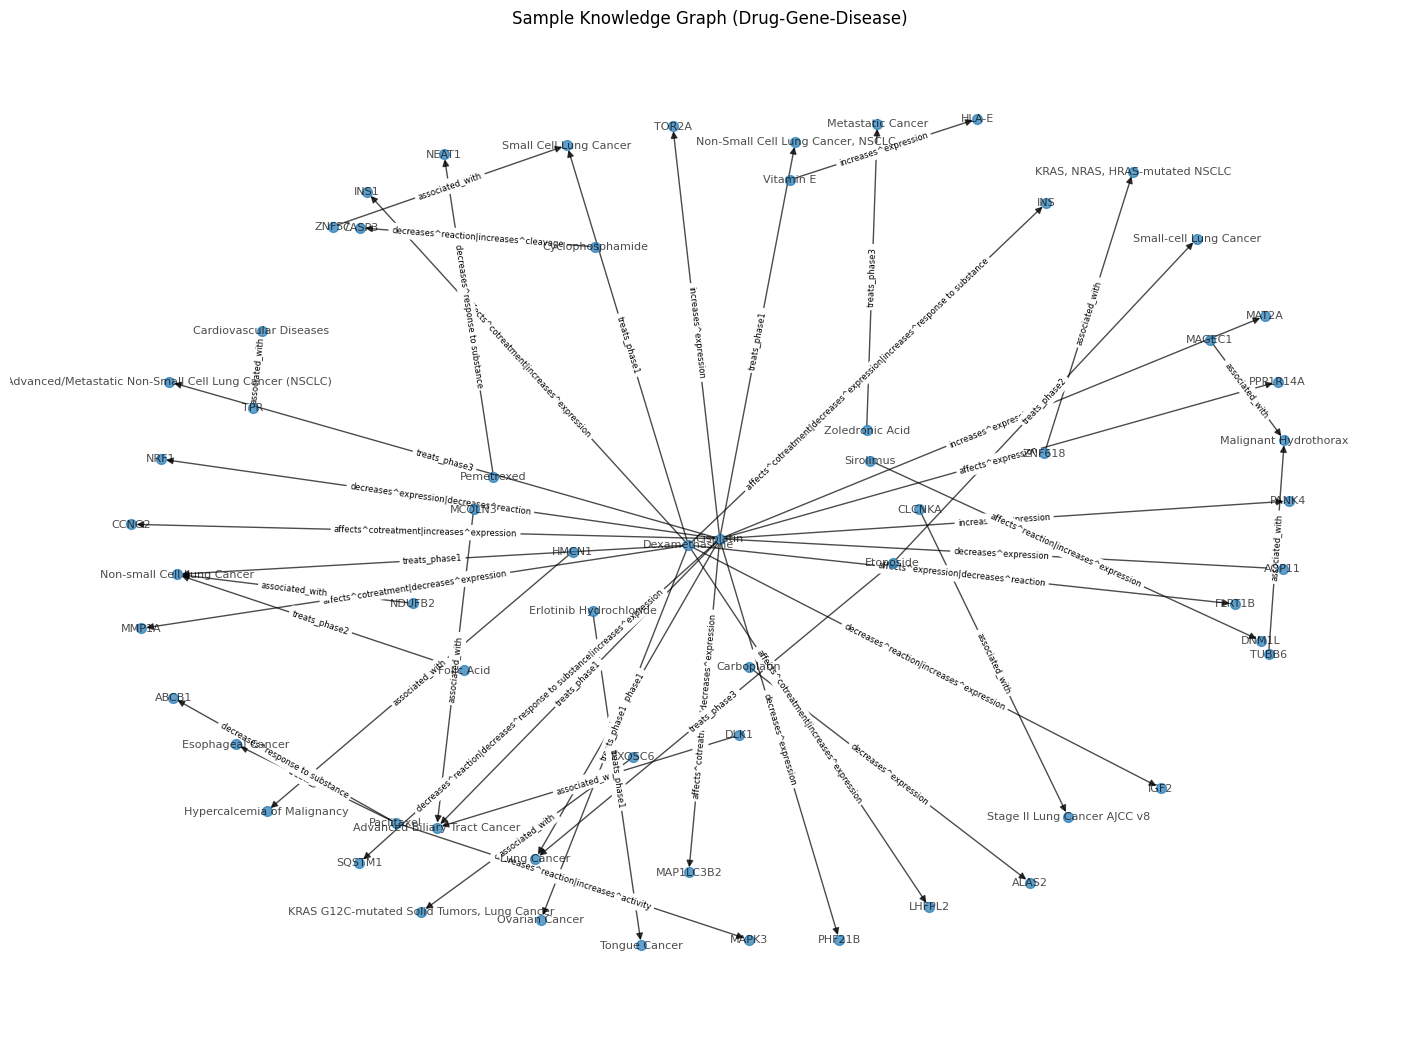

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(kg_triples.sample(50), source="source", target="target", edge_attr="relation", create_using=nx.DiGraph())

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, alpha=0.7)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
plt.title("Sample Knowledge Graph (Drug-Gene-Disease)")
plt.show()


/var/folders/xl/tf2bhvp95n1_1jwlykxyf4c80000gn/T/ipykernel_35473/2872209167.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


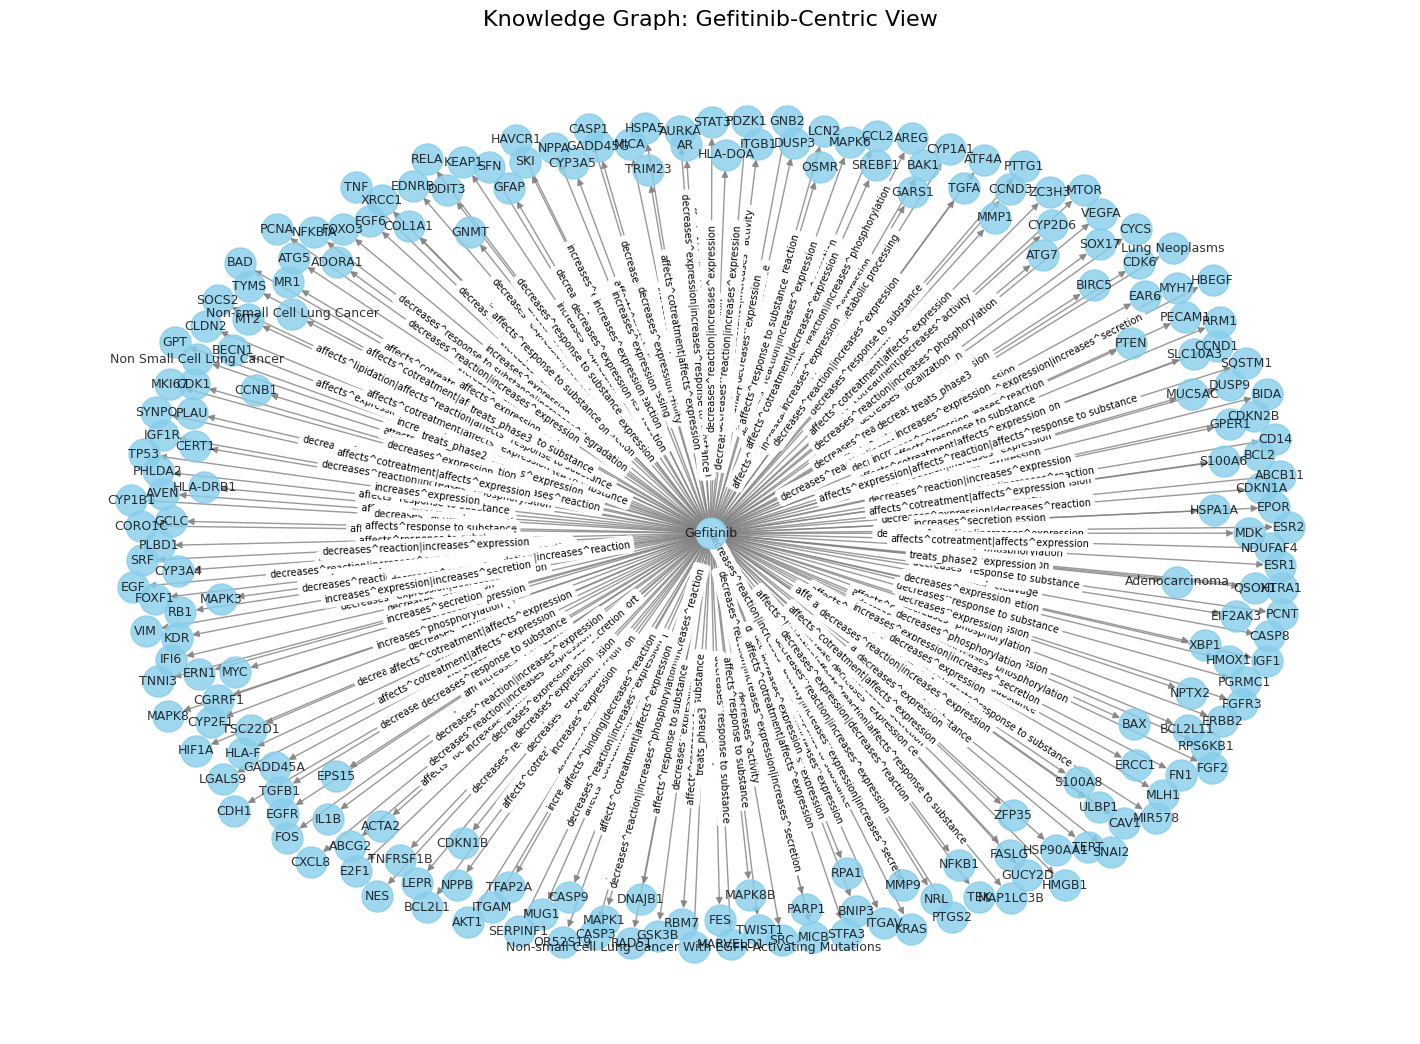

In [16]:
drug_name = "Gefitinib"

kg_sub = kg_triples[
    (kg_triples["source"].str.lower() == drug_name.lower()) |
    (kg_triples["target"].str.lower() == drug_name.lower())
].drop_duplicates()
import networkx as nx
import matplotlib.pyplot as plt

G_sub = nx.from_pandas_edgelist(kg_sub, source="source", target="target", edge_attr="relation", create_using=nx.DiGraph())

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_sub, k=0.5)
nx.draw(G_sub, pos, with_labels=True, node_size=500, font_size=9, node_color="#87CEEB", edge_color="gray", alpha=0.8)
edge_labels = nx.get_edge_attributes(G_sub, 'relation')
nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_size=7)
plt.title("Knowledge Graph: Gefitinib-Centric View", fontsize=16)
plt.tight_layout()
plt.show()


In [28]:
import os
import json
import pandas as pd
import openai
from dotenv import load_dotenv

load_dotenv()
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

kg_triples = pd.read_csv("/Users/jihangbc.edu/Downloads/kg_triples.csv")


def parse_question_with_llm(question: str) -> dict:
    prompt = f"""
You are a biomedical assistant. Extract the user's intent as JSON:
- query_type: one of ["drug_to_gene","drug_to_disease","gene_to_disease","disease_to_drug"]
- drug, gene, disease: strings or null

Example 1:
Q: What genes does Gefitinib affect?
→ {{"query_type":"drug_to_gene","drug":"Gefitinib","gene":null,"disease":null}}

Example 2:
Q: Which drugs affect genes associated with lung cancer?
→ {{"query_type":"disease_to_drug","drug":null,"gene":null,"disease":"lung cancer"}}

Now:
Q: {question}
→
"""
    resp = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role":"user","content":prompt}],
        temperature=0
    )
    text = resp.choices[0].message.content.strip()
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        # fallback for null→None
        fixed = text.replace("null","null")  # keep null, json.loads will handle it
        return json.loads(fixed)


def query_kg(intent: dict, kg_df: pd.DataFrame) -> pd.DataFrame:
    qt = intent.get("query_type")
    drug = intent.get("drug") or ""
    gene = intent.get("gene") or ""
    disease = intent.get("disease") or ""

    if qt == "drug_to_gene":
        return kg_df[
            (kg_df.source.str.lower() == drug.lower()) &
            (kg_df.relation.str.contains("affects|increases|decreases", case=False))
        ]

    if qt == "drug_to_disease":
        return kg_df[
            (kg_df.source.str.lower() == drug.lower()) &
            (kg_df.relation.str.startswith("treats"))
        ]

    if qt == "gene_to_disease":
        return kg_df[
            (kg_df.source.str.lower() == gene.lower()) &
            (kg_df.relation == "associated_with")
        ]

    if qt == "disease_to_drug":
        # 1) find all genes associated with the disease
        assoc = kg_df[
            (kg_df.relation == "associated_with") &
            (kg_df.target.str.lower() == disease.lower())
        ]["source"].unique().tolist()

        # 2) find all drugs affecting those genes
        return kg_df[
            (kg_df.relation.str.contains("affects|increases|decreases", case=False)) &
            (kg_df.target.str.lower().isin([g.lower() for g in assoc]))
        ]

    return pd.DataFrame()


def generate_answer(question: str, df: pd.DataFrame) -> str:
    if df.empty:
        return "No relevant information found in the knowledge graph."

    sample = df.head(10).to_dict(orient="records")
    facts = "\n".join(f"{r['source']} --[{r['relation']}]--> {r['target']}" for r in sample)

    prompt = f"""
You are a helpful biomedical assistant. The user asked:
"{question}"

Here are some KG facts:
{facts}

Write a concise English answer based on these facts.
"""
    resp = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role":"user","content":prompt}],
        temperature=0.5
    )
    return resp.choices[0].message.content.strip()


def answer_user_question(question: str) -> str:
    intent = parse_question_with_llm(question)
    print("🔍 Parsed intent:", intent)
    results = query_kg(intent, kg_triples)
    return generate_answer(question, results)


if __name__ == "__main__":
    q = input("💬 Ask a biomedical question: ")
    # What genes does Gefitinib affect?
    print("\n🧠 Answer:\n", answer_user_question(q))


2025-07-09 15:30:41,866 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔍 Parsed intent: {'query_type': 'drug_to_gene', 'drug': 'Gefitinib', 'gene': None, 'disease': None}


2025-07-09 15:30:49,187 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🧠 Answer:
 Gefitinib affects several genes. It decreases the activity of ABCB11 and ABCG2. It also affects the localization of ABCG2 and decreases its reaction and response to substances. Moreover, Gefitinib affects the cotreatment of ACTA2 by increasing its expression, but it also decreases ACTA2's expression in other contexts. It increases the secretion of ACTA2 as well. Furthermore, Gefitinib decreases the expression of ADORA1 and affects the reaction of AKT1 by decreasing its phosphorylation.


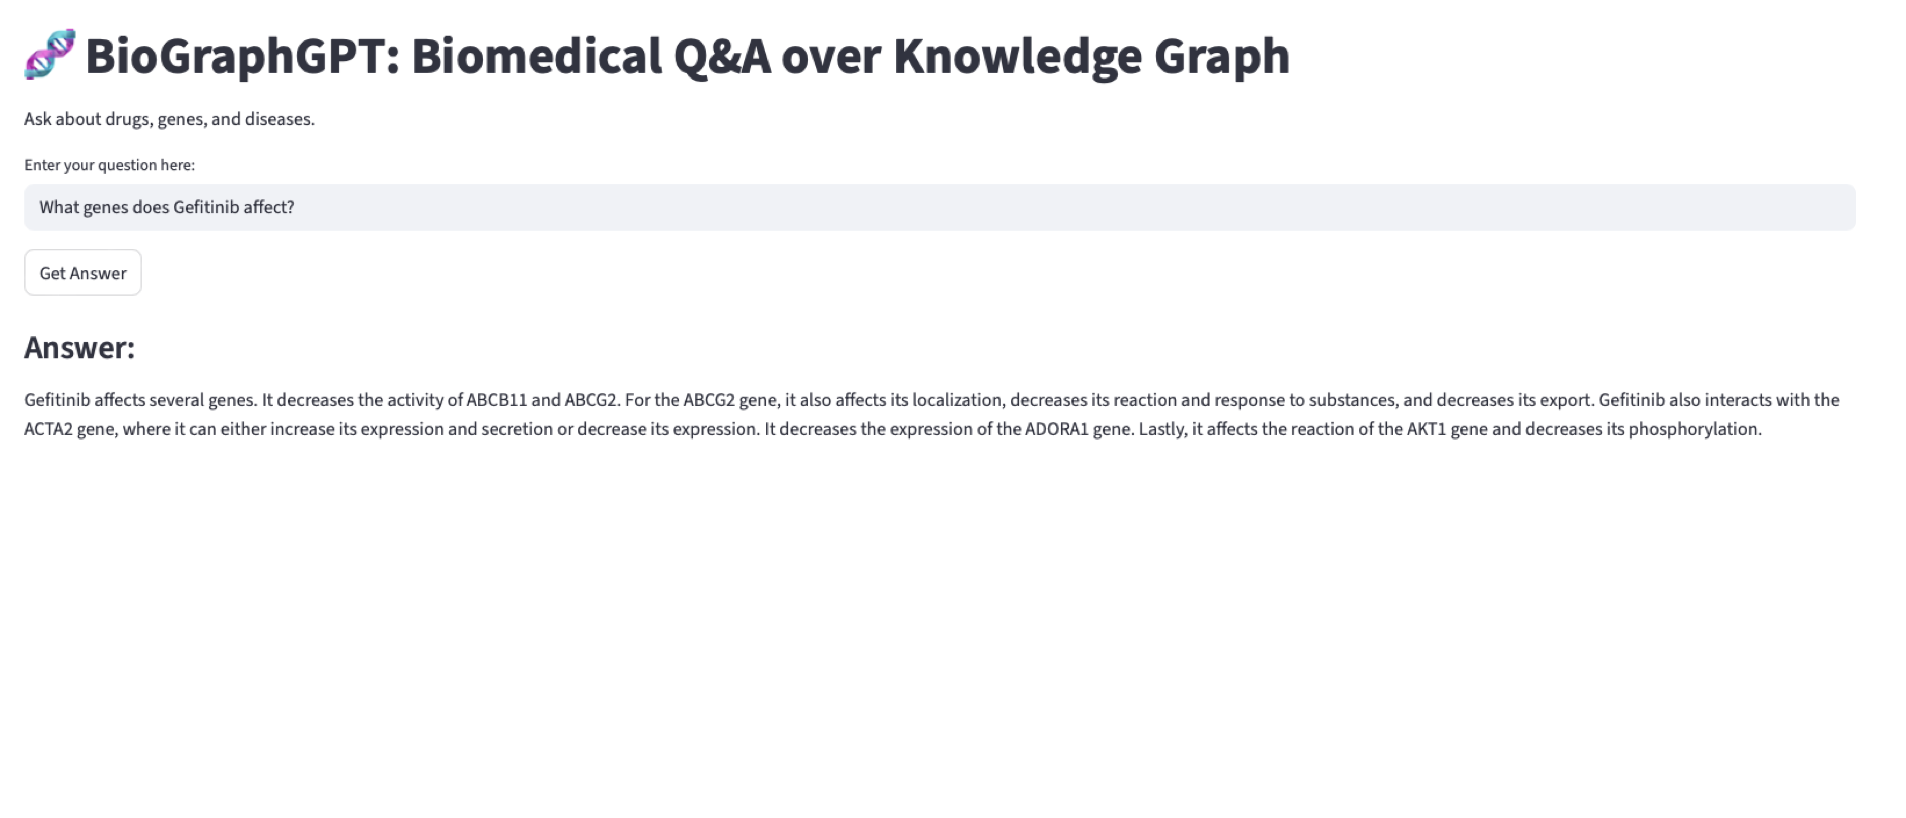

In [31]:
if __name__ == "__main__":
    q = input("💬 Ask a biomedical question: ")
    # Which drugs affect genes associated with lung cancer?
    print("\n🧠 Answer:\n", answer_user_question(q))

2025-07-09 21:12:45,249 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔍 Parsed intent: {'query_type': 'disease_to_drug', 'drug': None, 'gene': None, 'disease': 'lung cancer'}


2025-07-09 21:12:52,331 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🧠 Answer:
 The drug Gefitinib affects multiple genes associated with lung cancer. It decreases the activity of ABCB11 and ABCG2, while also affecting the localization and export of ABCG2. Gefitinib can also decrease the reaction or response to substances by ABCG2. In terms of gene ACTA2, Gefitinib can both increase and decrease its expression, as well as increase its secretion. Lastly, Gefitinib affects the AKT1 gene by altering its reaction and phosphorylation levels.


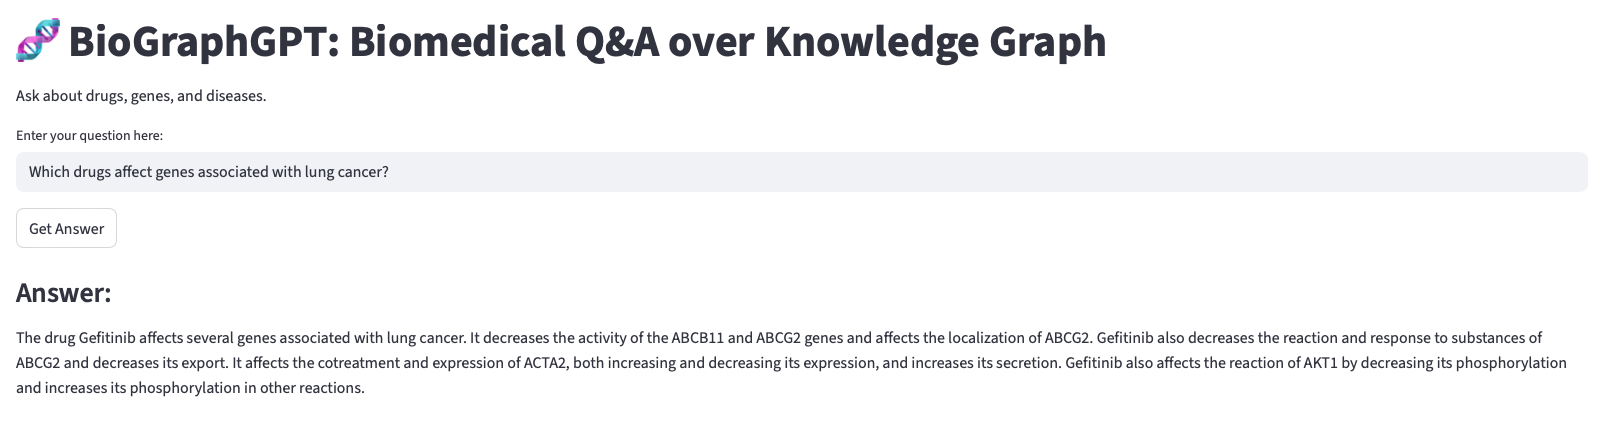

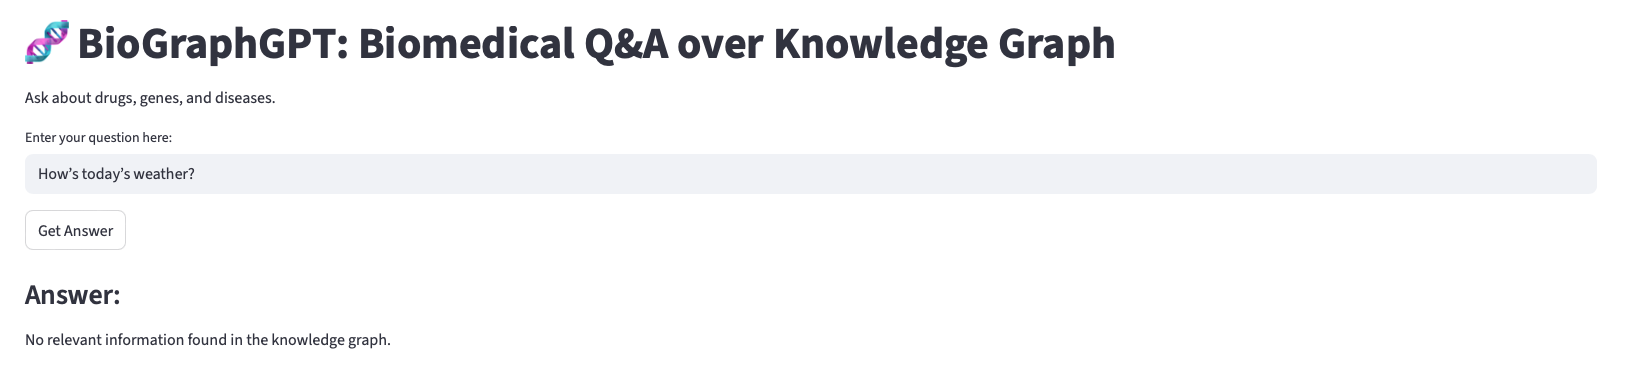